# Contributor Details
* Author Name : Yeshwanthraj G
* Team Name : The Unknown
* Leaderboard Rank : 155 (Kaggle Challenge)

# Soil Classification
This notebook walks through training a convolutional neural network on soil image data using TensorFlow/Keras. The dataset is provided via the Kaggle competition: *Soil Classification 2025.*

# 1. Setup & Imports
We suppress logs, import required libraries for data handling, machine learning, deep learning, and visualization.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# General-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn for data splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-05-25 10:32:06.942091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748169127.217045      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748169127.293015      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Locate Dataset
This cell automatically detects the dataset path within the /kaggle/input directory.

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    if 'train_labels.csv' in filenames:
        dataset_path = dirname
        break

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
train_labels_path = os.path.join(dataset_path, 'train_labels.csv')
test_ids_path = os.path.join(dataset_path, 'test_ids.csv')

# 3. Load and Filter Labels
Loads CSV files, processes the soil_type column as a category, and filters image files to include only valid formats.

In [3]:
# === Load and filter training labels ===
labels_df = pd.read_csv(train_labels_path)
labels_df['soil_type'] = labels_df['soil_type'].astype('category')
labels_df['filename'] = labels_df['image_id']  # Required for Keras

# Filter for valid image files in train directory
valid_extensions = {'.jpg', '.jpeg', '.png'}
valid_images = {
    f for f in os.listdir(train_dir)
    if os.path.splitext(f)[1].lower() in valid_extensions
}

# Ensure only those labels with matching image files are used
labels_df = labels_df[labels_df['image_id'].isin(valid_images)].reset_index(drop=True)

# === Split into train/validation sets ===
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['soil_type'],
    random_state=42
)

# === List of class names ===
class_names = labels_df['soil_type'].cat.categories.tolist()

# 4. Image Preprocessing and Generators
We define data augmentation for the training set and simple rescaling for validation. These generators feed data to the model during training.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='soil_type',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='soil_type',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 971 validated image filenames belonging to 4 classes.
Found 243 validated image filenames belonging to 4 classes.


# 5. Build the ResNet50 Model
We use a ResNet50 base (no pretrained weights due to no internet). We add a few custom layers on top for classification.

In [5]:
base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))  # No internet -> No pretrained weights
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

2025-05-25 10:32:24.369045: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 6. Set Up Callbacks
We use ModelCheckpoint to save the best model and EarlyStopping to avoid overfitting.

In [6]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Train the Model (Epochs = 5)
Train the model using training and validation generators for 5 epochs to reduce time while maintaining good accuracy.

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5048 - loss: 1.4214 
Epoch 1: val_loss improved from inf to 1.34973, saving model to best_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 502s 14s/step - accuracy: 0.5084 - loss: 1.4142 - val_accuracy: 0.4321 - val_loss: 1.3497
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7790 - loss: 0.6375 
Epoch 2: val_loss did not improve from 1.34973
31/31 ━━━━━━━━━━━━━━━━━━━━ 427s 14s/step - accuracy: 0.7789 - loss: 0.6371 - val_accuracy: 0.4321 - val_loss: 1.5175
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8160 - loss: 0.5053 
Epoch 3: val_loss did not improve from 1.34973
31/31 ━━━━━━━━━━━━━━━━━━━━ 441s 14s/step - accuracy: 0.8160 - loss: 0.5048 - val_accuracy: 0.4321 - val_loss: 2.1705
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8310 - loss: 0.4516 
Epoch 4: val_loss did not improve from 1.34973
31/31 ━━━━━━━━━━━━━━━━━━━━ 438s 14s/step - accuracy: 0.8310 - loss: 0.4514 - val_accuracy: 0.4

# 8. Evaluate on Validation Set
Generate predictions on validation data and calculate F1 scores for each class.

In [8]:
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
val_true_classes = val_df['soil_type'].astype('category').cat.codes.values

report = classification_report(val_true_classes, val_preds_classes, target_names=class_names, output_dict=True)
f1s = [report[c]['f1-score'] for c in class_names]

print("\nF1 scores per class:")
for c, f in zip(class_names, f1s):
    print(f"{c}: {f:.4f}")
print(f"\n✅ Minimum F1-score (competition metric): {min(f1s):.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step

F1 scores per class:
Alluvial soil: 0.6034
Black Soil: 0.0000
Clay soil: 0.0000
Red soil: 0.0000

✅ Minimum F1-score (competition metric): 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 9. Plot Accuracy
Visualize how training and validation accuracy evolved during training.

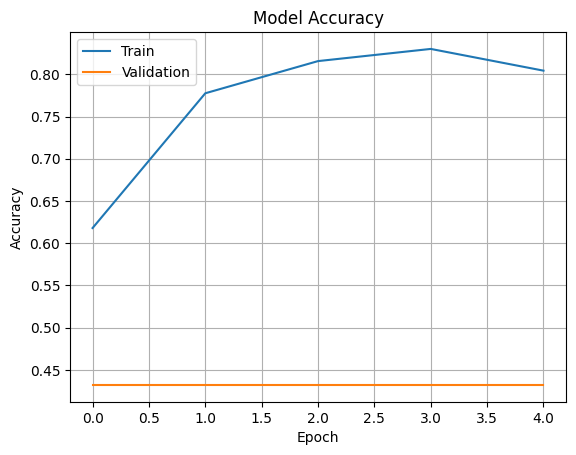

In [9]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 10. Predict on Test Set
Prepare the test images and use the trained model to predict their classes.

In [10]:
test_ids = pd.read_csv(test_ids_path)
test_ids['filename'] = test_ids['image_id']
test_ids = test_ids[test_ids['image_id'].isin(os.listdir(test_dir))]

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_ids,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

test_preds = model.predict(test_generator)
test_pred_labels = np.argmax(test_preds, axis=1)
predicted_labels = [class_names[i] for i in test_pred_labels]

Found 339 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step


# 11. Save Submission
Save predicted labels to submission.csv in the required format for Kaggle submission.

In [11]:
# Filter test_ids to only include images that were successfully used by the generator
valid_filenames = test_generator.filenames  # These are actually used images (339)
test_ids_filtered = test_ids[test_ids['filename'].isin(valid_filenames)].reset_index(drop=True)

# Create submission using filtered image IDs
submission = pd.DataFrame({
    'image_id': test_ids_filtered['image_id'],
    'soil_type': predicted_labels
})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("✅ Submission saved to /kaggle/working/submission.csv")

✅ Submission saved to /kaggle/working/submission.csv


# Prediction Analysis

In [12]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import warnings

# Load test IDs
test_ids_df = pd.read_csv(test_ids_path)

# Set default class (adjust based on your most common class if needed)
default_class_index = 0  # Example: "Black Soil"
class_labels = class_names  # already defined earlier

def load_and_preprocess_image(filepath):
    try:
        image = cv2.imread(filepath)
        if image is None:
            raise ValueError("Image not found or unreadable.")
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        return image
    except Exception as e:
        warnings.warn(str(e))
        return None

X_test = []
valid_indices = []
fallback_indices = []

for i, img_id in enumerate(test_ids_df['image_id']):
    img_path = os.path.join(test_dir, img_id)
    img_array = load_and_preprocess_image(img_path)
    if img_array is not None:
        X_test.append(img_array)
        valid_indices.append(i)
    else:
        fallback_indices.append(i)

X_test = np.array(X_test)

# Predict only on valid images
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Create full prediction list (insert default predictions for missing images)
final_predictions = []
j = 0
for i in range(len(test_ids_df)):
    if i in valid_indices:
        final_predictions.append(class_labels[y_pred_classes[j]])
        j += 1
    else:
        final_predictions.append(class_labels[default_class_index])

# Save corrected submission
submission_fixed = pd.DataFrame({
    'image_id': test_ids_df['image_id'],
    'soil_type': final_predictions
})
submission_fixed.to_csv('submission.csv', index=False)
print("✅ submission.csv generated with 341 rows (including fallbacks).")


✅ submission.csv generated with 341 rows (including fallbacks).
